In [235]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import pearsonr

In [236]:
diagnoses_df = pd.read_csv('cleaned_D_ICD_DIAGNOSES.csv')
patients_df = pd.read_csv('cleaned_PATIENTS.csv')
prescriptions_df = pd.read_csv('cleaned_PRESCRIPTIONS.csv', low_memory=False)

In [237]:
diagnoses_df.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,tb pneumonia-oth test,"tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,tb pneumothorax-unspec,"tuberculous pneumothorax, unspecified"
2,176,01171,tb pneumothorax-no exam,"tuberculous pneumothorax, bacteriological or h..."
3,177,01172,tb pneumothorx-exam unkn,"tuberculous pneumothorax, bacteriological or h..."
4,178,01173,tb pneumothorax-micro dx,"tuberculous pneumothorax, tubercle bacilli fou..."


In [238]:
patients_df.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13,NaN,NaN,NaN,0
1,235,250,F,2164-12-27,2188-11-22,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15,NaN,NaN,NaN,0
3,237,252,M,2078-03-06,NaN,NaN,NaN,0
4,238,253,F,2089-11-26,NaN,NaN,NaN,0


In [239]:
prescriptions_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE
0,2214776,6,107064,NaN,2175-06-11,2175-06-12,MAIN,tacrolimus,Tacrolimus,Tacrolimus,TACR1,021796,469061711.0,1mg Capsule,2.0,mg,2,CAP,po
1,2214775,6,107064,NaN,2175-06-11,2175-06-12,MAIN,warfarin,Warfarin,Warfarin,WARF5,006562,56017275.0,5mg Tablet,5.0,mg,1,TAB,po
2,2216265,6,107064,NaN,2175-06-11,2175-06-12,BASE,d5w,NaN,NaN,HEPBASE,NaN,0.0,HEPARIN BASE,250.0,ml,250,ml,iv
3,2214773,6,107064,NaN,2175-06-11,2175-06-12,MAIN,furosemide,Furosemide,Furosemide,FURO20,008208,54829725.0,20mg Tablet,20.0,mg,1,TAB,po
4,2214774,6,107064,NaN,2175-06-11,2175-06-15,MAIN,warfarin,Warfarin,Warfarin,WARF0,014198,56016975.0,Check with MD for Dose,1.0,dose,1,dose,po


In [240]:
prescriptions_df.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTDATE', 'ENDDATE',
       'DRUG_TYPE', 'DRUG', 'DRUG_NAME_POE', 'DRUG_NAME_GENERIC',
       'FORMULARY_DRUG_CD', 'GSN', 'NDC', 'PROD_STRENGTH', 'DOSE_VAL_RX',
       'DOSE_UNIT_RX', 'FORM_VAL_DISP', 'FORM_UNIT_DISP', 'ROUTE'],
      dtype='object')

In [241]:
prescriptions_df["DRUG"].nunique()

3798

In [242]:
prescriptions_df["DRUG_TYPE"].describe()

count     3859168
unique          3
top          MAIN
freq      2930412
Name: DRUG_TYPE, dtype: object

In [243]:
prescriptions_df["DRUG_NAME_GENERIC"].nunique()

2832

In [244]:
prescriptions_df["DRUG_NAME_POE"].nunique()


3916

In [245]:
prescriptions_df["FORMULARY_DRUG_CD"].nunique()


3241

In [246]:
prescriptions_df['STARTDATE'] = pd.to_datetime(prescriptions_df['STARTDATE'])
prescriptions_df['ENDDATE'] = pd.to_datetime(prescriptions_df['ENDDATE'])
prescriptions_df['DURATION'] = (prescriptions_df['ENDDATE'] - prescriptions_df['STARTDATE']).dt.days

# Merge datasets
merged_df = pd.merge(patients_df[['SUBJECT_ID', 'EXPIRE_FLAG']], prescriptions_df[['SUBJECT_ID', 'DRUG_NAME_GENERIC', 'DRUG_TYPE', 'DRUG', 'DURATION', 'NDC']], on='SUBJECT_ID')

# Start cleaning the data + make new dataset csv

In [247]:
merged_df.isna().sum()

SUBJECT_ID                 0
EXPIRE_FLAG                0
DRUG_NAME_GENERIC    1595328
DRUG_TYPE                  0
DRUG                       0
DURATION                   0
NDC                     3057
dtype: int64

In [248]:
# Drop all nan values in NDC
merged_df.dropna(subset=['NDC'], inplace=True)
merged_df.shape

(3856111, 7)

In [249]:
merged_df.dtypes

SUBJECT_ID             int64
EXPIRE_FLAG            int64
DRUG_NAME_GENERIC     object
DRUG_TYPE             object
DRUG                  object
DURATION               int64
NDC                  float64
dtype: object

In [250]:
# Convert to int (get rid of .0)
merged_df['NDC'] = merged_df['NDC'].astype(int)

# Convert to String
merged_df['NDC'] = merged_df['NDC'].astype(str)

# Pad with leading zeros to ensure length is 10
merged_df['NDC'] = merged_df['NDC'].apply(lambda x: x.zfill(10))

# Count entries of length 11
entries_length_11 = merged_df[merged_df['NDC'].str.len() == 11].shape[0]

# Drop entries of length 11
merged_df = merged_df[merged_df['NDC'].str.len() <= 10]

print(f"Number of entries of length 11 and dropped: {entries_length_11}")

Number of entries of length 11 and dropped: 928315


In [251]:
merged_df.head()

,SUBJECT_ID,EXPIRE_FLAG,DRUG_NAME_GENERIC,DRUG_TYPE,DRUG,DURATION,NDC
0,249,0,Trandolapril,MAIN,trandolapril,0,0074227811
1,249,0,NaN,BASE,d5w,1,0000000000
2,249,0,NaN,MAIN,vancomycin hcl,1,0002735501
3,249,0,NaN,BASE,iso-osmotic dextrose,1,0000000000
4,249,0,Captopril,MAIN,captopril,2,0003045051


In [252]:
# ensure it's a copy to avoid SettingWithCopyWarning
merged_df = merged_df.copy()

# convert codes into xxxx-xxxx-xx format
merged_df['NDC'] = merged_df['NDC'].apply(lambda x: f"{x[:4]}-{x[4:8]}-{x[8:]}")

In [253]:
merged_df["NDC"].describe()

count          2927796
unique            2615
top       0000-0000-00
freq            577126
Name: NDC, dtype: object

In [254]:
merged_df.shape

(2927796, 7)

In [255]:
merged_df.head()

,SUBJECT_ID,EXPIRE_FLAG,DRUG_NAME_GENERIC,DRUG_TYPE,DRUG,DURATION,NDC
0,249,0,Trandolapril,MAIN,trandolapril,0,0074-2278-11
1,249,0,NaN,BASE,d5w,1,0000-0000-00
2,249,0,NaN,MAIN,vancomycin hcl,1,0002-7355-01
3,249,0,NaN,BASE,iso-osmotic dextrose,1,0000-0000-00
4,249,0,Captopril,MAIN,captopril,2,0003-0450-51


In [256]:
drug_code = pd.read_csv("ndc_map 2020_06_17 (atc5 atc4 ingredients).csv", low_memory=False)
drug_code.head()

,ndc,rxcui,atc4,atc4_name,in_rxcui,has_min,in_tty,in_name,in_synonym,in_umlscui,atc5,ddd,u,adm_r,whocc_note
0,0002-0800-01,540930.0,NaN,NaN,11295.0,False,IN,water,NaN,C0043047,NaN,NaN,NaN,NaN,NaN
1,0002-1200-30,1716302.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0002-1200-50,1716302.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0002-1210-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0002-1210-50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [257]:
merged_df = pd.merge(merged_df, drug_code, left_on='NDC', right_on='ndc', how='left')

In [258]:
merged_df.shape

(6943995, 22)

In [259]:
merged_df.isna().sum()

SUBJECT_ID                 0
EXPIRE_FLAG                0
DRUG_NAME_GENERIC    4882486
DRUG_TYPE                  0
DRUG                       0
DURATION                   0
NDC                        0
ndc                  1598596
rxcui                1598596
atc4                 1820929
atc4_name            1820929
in_rxcui             1602622
has_min              1602622
in_tty               1602622
in_name              1602622
in_synonym           6568423
in_umlscui           1602622
atc5                 3182837
ddd                  6912707
u                    6912707
adm_r                6912707
whocc_note           6943990
dtype: int64

In [260]:
merged_df.dropna(subset=["atc4", "atc4_name", 'atc5'], inplace=True)

In [261]:
merged_df.shape

(3761158, 22)

In [262]:
merged_df.drop(["ndc", "ddd", "u", "adm_r", "whocc_note"], axis=1, inplace=True, errors='ignore')

In [263]:
merged_df.isna().sum()

SUBJECT_ID                 0
EXPIRE_FLAG                0
DRUG_NAME_GENERIC    2930623
DRUG_TYPE                  0
DRUG                       0
DURATION                   0
NDC                        0
rxcui                      0
atc4                       0
atc4_name                  0
in_rxcui                   0
has_min                    0
in_tty                     0
in_name                    0
in_synonym           3736047
in_umlscui                 0
atc5                       0
dtype: int64

In [264]:
merged_df.shape

(3761158, 17)

In [265]:
merged_df.head()

,SUBJECT_ID,EXPIRE_FLAG,DRUG_NAME_GENERIC,DRUG_TYPE,DRUG,DURATION,NDC,rxcui,atc4,atc4_name,in_rxcui,has_min,in_tty,in_name,in_synonym,in_umlscui,atc5
12,249,0,NaN,BASE,ns,1,0338-0049-38,1807632.0,A12CA,Sodium,9863.0,False,IN,sodium chloride,NaN,C0037494,A12CA01
13,249,0,NaN,BASE,ns,1,0338-0049-38,1807632.0,B05CB,Salt solutions,9863.0,False,IN,sodium chloride,NaN,C0037494,B05CB01
14,249,0,NaN,BASE,ns,1,0338-0049-38,1807632.0,B05XA,Electrolyte solutions,9863.0,False,IN,sodium chloride,NaN,C0037494,B05XA03
16,249,0,NaN,MAIN,humulin-r insulin,1,0002-8215-01,311036.0,A10AB,"Insulins and analogues for injection, fast-acting",253182.0,False,IN,"insulin, regular, human",NaN,C0795635,A10AB01
17,249,0,NaN,MAIN,humulin-r insulin,1,0002-8215-01,311036.0,A10AC,"Insulins and analogues for injection, intermed...",253182.0,False,IN,"insulin, regular, human",NaN,C0795635,A10AC01


In [266]:
merged_df["SUBJECT_ID"].nunique()

37619

In [267]:
merged_df['atc3'] = merged_df['atc4'].str[:4]
merged_df['atc2'] = merged_df['atc4'].str[:3]
merged_df['atc1'] = merged_df['atc4'].str[0]

In [268]:
print(merged_df["atc5"].nunique())
print(merged_df["atc4"].nunique())
print(merged_df["atc3"].nunique())
print(merged_df["atc2"].nunique())
print(merged_df["atc1"].nunique())

611
312
141
73
14


In [269]:
merged_df["atc4_name"].nunique()

287

In [270]:
merged_df.to_csv('./cleaned_drug_atc_expire.csv', index=False)


---

# Read new cleaned df

In [271]:
drug_expire = pd.read_csv('cleaned_drug_atc_expire.csv')

In [272]:
drug_expire.head()

,SUBJECT_ID,EXPIRE_FLAG,DRUG_NAME_GENERIC,DRUG_TYPE,DRUG,DURATION,NDC,rxcui,atc4,atc4_name,in_rxcui,has_min,in_tty,in_name,in_synonym,in_umlscui,atc5,atc3,atc2,atc1
0,249,0,NaN,BASE,ns,1,0338-0049-38,1807632.0,A12CA,Sodium,9863.0,False,IN,sodium chloride,NaN,C0037494,A12CA01,A12C,A12,A
1,249,0,NaN,BASE,ns,1,0338-0049-38,1807632.0,B05CB,Salt solutions,9863.0,False,IN,sodium chloride,NaN,C0037494,B05CB01,B05C,B05,B
2,249,0,NaN,BASE,ns,1,0338-0049-38,1807632.0,B05XA,Electrolyte solutions,9863.0,False,IN,sodium chloride,NaN,C0037494,B05XA03,B05X,B05,B
3,249,0,NaN,MAIN,humulin-r insulin,1,0002-8215-01,311036.0,A10AB,"Insulins and analogues for injection, fast-acting",253182.0,False,IN,"insulin, regular, human",NaN,C0795635,A10AB01,A10A,A10,A
4,249,0,NaN,MAIN,humulin-r insulin,1,0002-8215-01,311036.0,A10AC,"Insulins and analogues for injection, intermed...",253182.0,False,IN,"insulin, regular, human",NaN,C0795635,A10AC01,A10A,A10,A


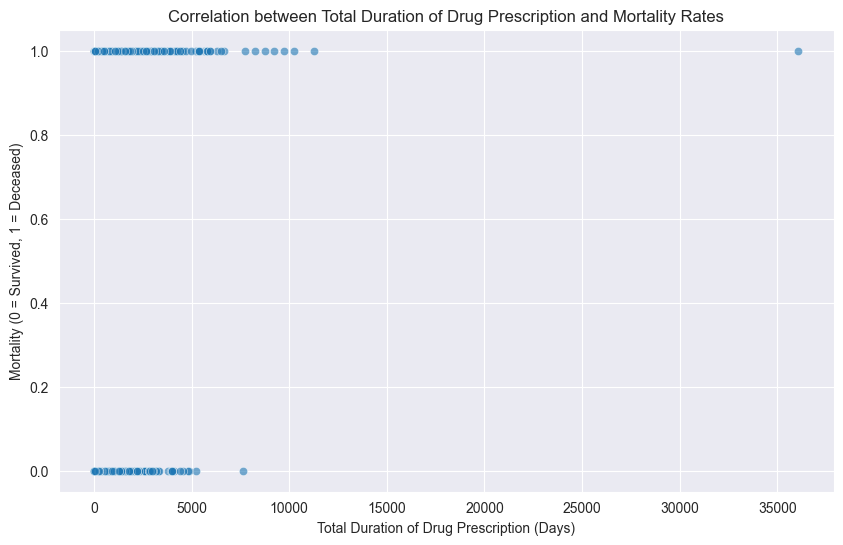

0.12641865829313695

In [273]:
# Aggregate the total duration of drug prescriptions per patient
patient_duration = drug_expire.groupby('SUBJECT_ID')['DURATION'].sum().reset_index()

# Merge this with the mortality flag to get a dataframe suitable for correlation analysis
mortality_duration = patient_duration.merge(drug_expire[['SUBJECT_ID', 'EXPIRE_FLAG']].drop_duplicates(), on='SUBJECT_ID')

# Scatter plot for correlation between the total duration of drug prescription and mortality rates
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mortality_duration, x='DURATION', y='EXPIRE_FLAG', alpha=0.6)
plt.title('Correlation between Total Duration of Drug Prescription and Mortality Rates')
plt.xlabel('Total Duration of Drug Prescription (Days)')
plt.ylabel('Mortality (0 = Survived, 1 = Deceased)')
plt.grid(True)
plt.show()

# Calculate the correlation coefficient for duration and expire flag
correlation_coef = mortality_duration['DURATION'].corr(mortality_duration['EXPIRE_FLAG'])
correlation_coef

In [274]:
drug_expire.columns

Index(['SUBJECT_ID', 'EXPIRE_FLAG', 'DRUG_NAME_GENERIC', 'DRUG_TYPE', 'DRUG',
       'DURATION', 'NDC', 'rxcui', 'atc4', 'atc4_name', 'in_rxcui', 'has_min',
       'in_tty', 'in_name', 'in_synonym', 'in_umlscui', 'atc5', 'atc3', 'atc2',
       'atc1'],
      dtype='object')

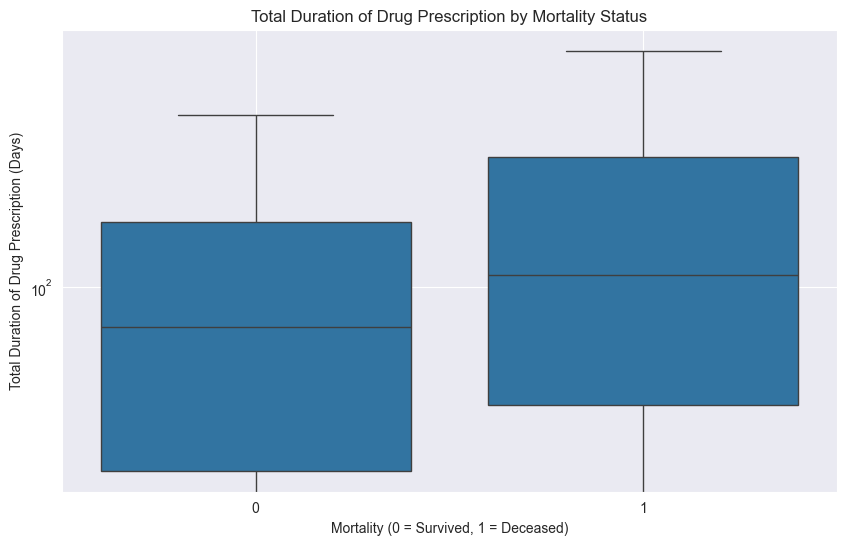

In [275]:
# Aggregate the total duration of drug prescriptions per patient
patient_duration = drug_expire.groupby('SUBJECT_ID')['DURATION'].sum().reset_index()

# Merge this with the mortality flag to get a dataframe suitable for correlation analysis
mortality_duration = patient_duration.merge(drug_expire[['SUBJECT_ID', 'EXPIRE_FLAG']].drop_duplicates(), on='SUBJECT_ID')

# Create a boxplot with log scale
plt.figure(figsize=(10, 6))
sns.boxplot(data=mortality_duration, x='EXPIRE_FLAG', y='DURATION', showfliers=False)
plt.yscale('log')  # Set y-axis to log scale
plt.title('Total Duration of Drug Prescription by Mortality Status')
plt.xlabel('Mortality (0 = Survived, 1 = Deceased)')
plt.ylabel('Total Duration of Drug Prescription (Days)')
plt.grid(True)
plt.show()

In [291]:
mortality_duration.describe()

,SUBJECT_ID,DURATION,EXPIRE_FLAG
count,37619.000000,37619.000000,37619.000000
mean,38959.685957,195.286079,0.373030
std,29324.019556,421.750511,0.483616
min,4.000000,0.000000,0.000000
25%,14586.000000,30.000000,0.000000
50%,28802.000000,84.000000,0.000000
75%,63694.000000,202.000000,1.000000
max,99999.000000,36078.000000,1.000000


In [276]:
drug_class = 'atc1'

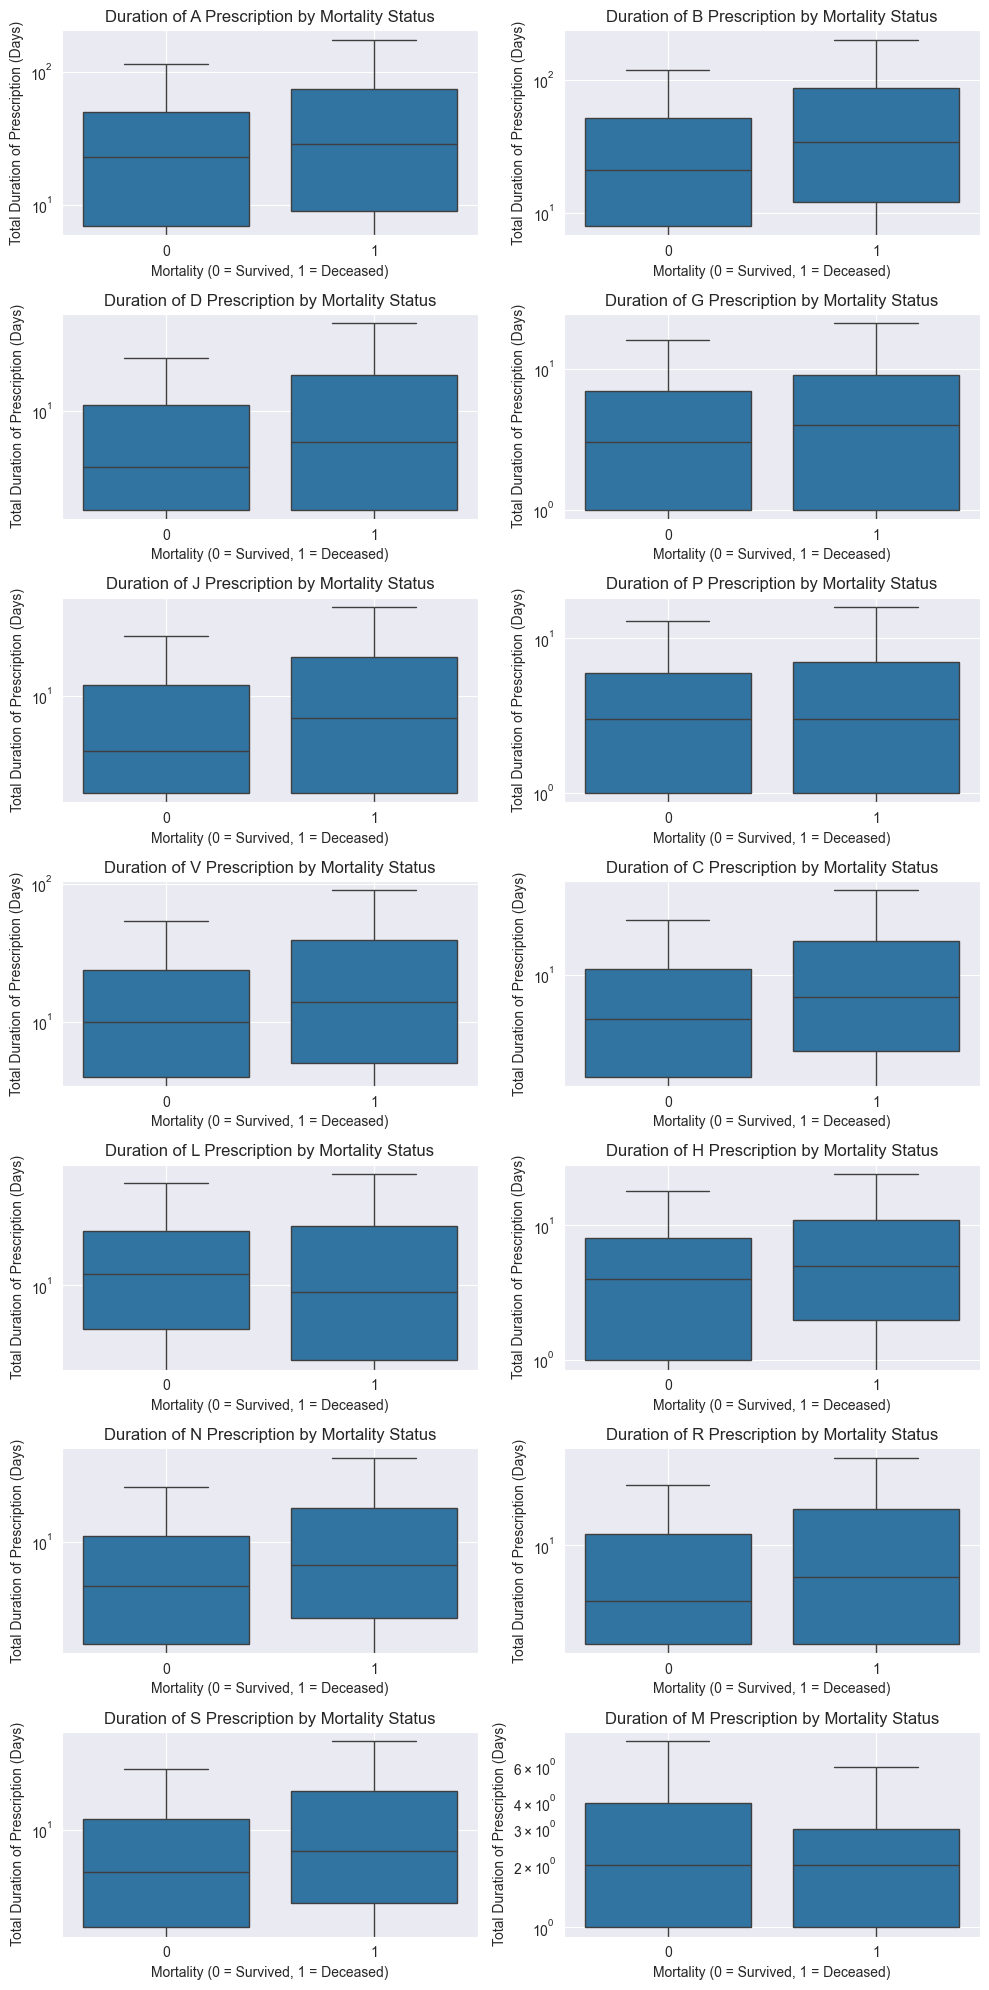

In [277]:
# 1. Aggregate Total Duration
drug_type_duration = drug_expire.groupby(['SUBJECT_ID', drug_class])['DURATION'].sum().reset_index()

# 2. Merge with Mortality Flag
mortality_drug_type = drug_type_duration.merge(drug_expire[['SUBJECT_ID', 'EXPIRE_FLAG']].drop_duplicates(), on='SUBJECT_ID')

# Plot setup
plt.figure(figsize=(10, 20))

# 3. Create Boxplots
for i, drug_type in enumerate(mortality_drug_type[drug_class].unique(), start=1):
    plt.subplot(7, 2, i)  # Adjust subplot grid as necessary
    sns.boxplot(data=mortality_drug_type[mortality_drug_type[drug_class] == drug_type], 
                x='EXPIRE_FLAG', y='DURATION', showfliers=False)
    plt.yscale('log')
    plt.title(f'Duration of {drug_type} Prescription by Mortality Status')
    plt.xlabel('Mortality (0 = Survived, 1 = Deceased)')
    plt.ylabel('Total Duration of Prescription (Days)')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [278]:
# The goal is to have each entry include patient ID, drug information, total duration of that particular drug, and the number of times this drug prescribed to this patient.

# Grouping the data by 'SUBJECT_ID' and 'DRUG_NAME_GENERIC' to aggregate the total duration and count the prescriptions
drug_patient_summary = drug_expire.groupby(['SUBJECT_ID', drug_class]).agg(
    Total_Duration=('DURATION', 'sum'),
    Prescription_Count=('atc4', 'count')
).reset_index()

# Merging the summary data back with the original to include 'EXPIRE_FLAG'
drug_patient_complete = pd.merge(
    drug_patient_summary,
    drug_expire[['SUBJECT_ID', drug_class, 'EXPIRE_FLAG']].drop_duplicates(),
    on=['SUBJECT_ID', drug_class],
    how='left'
)

# Now, proceed with the analysis similar to before, focusing on the top drugs but considering the newly structured data
# Selecting the top most frequently prescribed drugs
top_drugs = drug_patient_complete[drug_class].value_counts().head(40).index.tolist()

# Filter the dataset to include only the top drugs
top_drugs_df = drug_patient_complete[drug_patient_complete[drug_class].isin(top_drugs)]

# Aggregate data by drug and mortality flag, summing the total duration and counting the number of prescriptions
drug_mortality_summary = top_drugs_df.groupby([drug_class, 'EXPIRE_FLAG']).agg(
    Total_Duration=('Total_Duration', 'sum'),
    Prescription_Count=('Prescription_Count', 'sum')
).unstack(fill_value=0)

# Calculate the mortality rate as before
drug_mortality_summary['Mortality Rate'] = drug_mortality_summary[('Prescription_Count', 1)] / (
    drug_mortality_summary[('Prescription_Count', 0)] + drug_mortality_summary[('Prescription_Count', 1)]
)

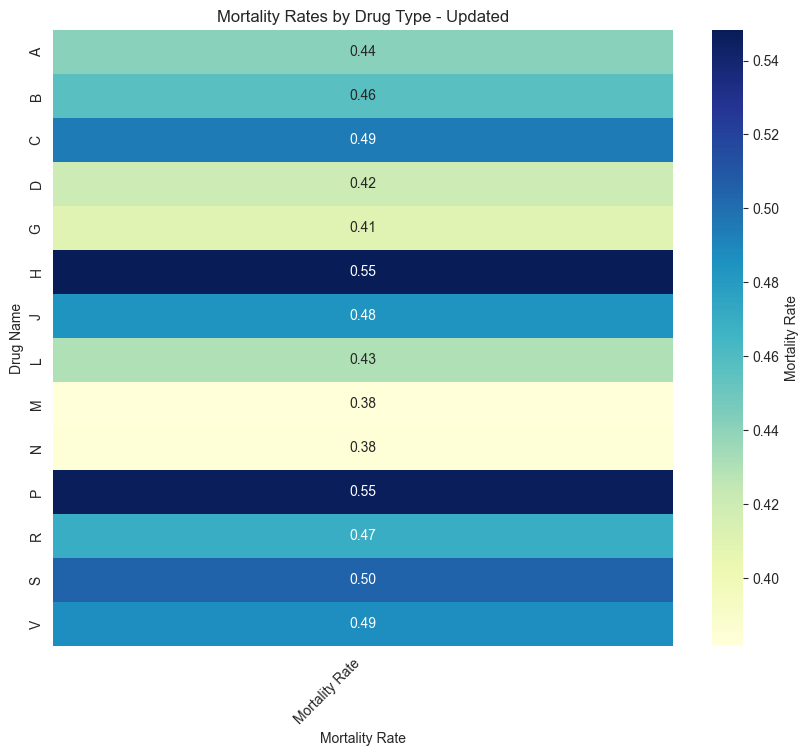

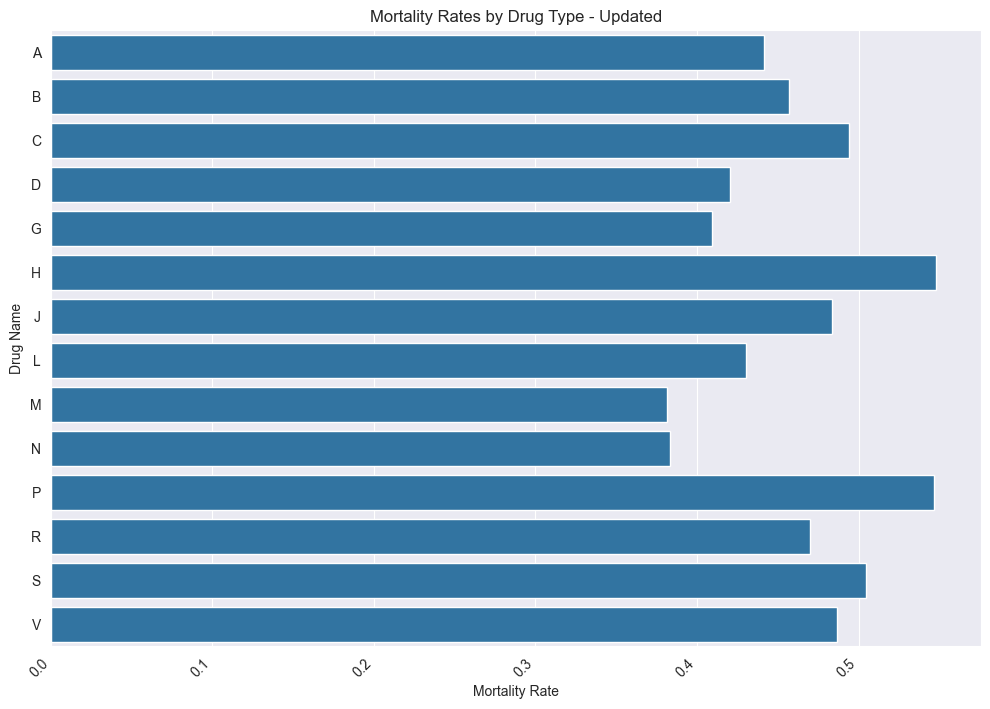

In [279]:
# Preparing data for the visualizations
heatmap_data = drug_mortality_summary[['Mortality Rate']].reset_index()
heatmap_data.columns = [drug_class, 'Mortality Rate']
heatmap_data.set_index(drug_class, inplace=True)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data=heatmap_data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Mortality Rate'}, fmt=".2f")
plt.title('Mortality Rates by Drug Type - Updated')
plt.xlabel('Mortality Rate')
plt.ylabel('Drug Name')
plt.xticks(rotation=45, ha='right')
plt.show()

# Plotting the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='Mortality Rate', y=drug_class, data=heatmap_data.reset_index())
plt.title('Mortality Rates by Drug Type - Updated')
plt.xlabel('Mortality Rate')
plt.ylabel('Drug Name')
plt.xticks(rotation=45, ha='right')
plt.show()

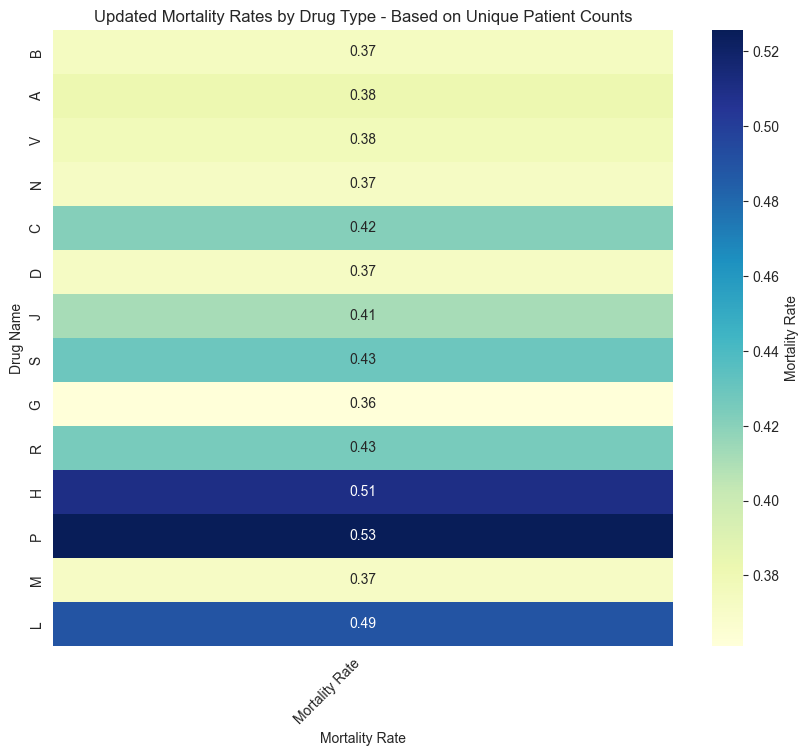

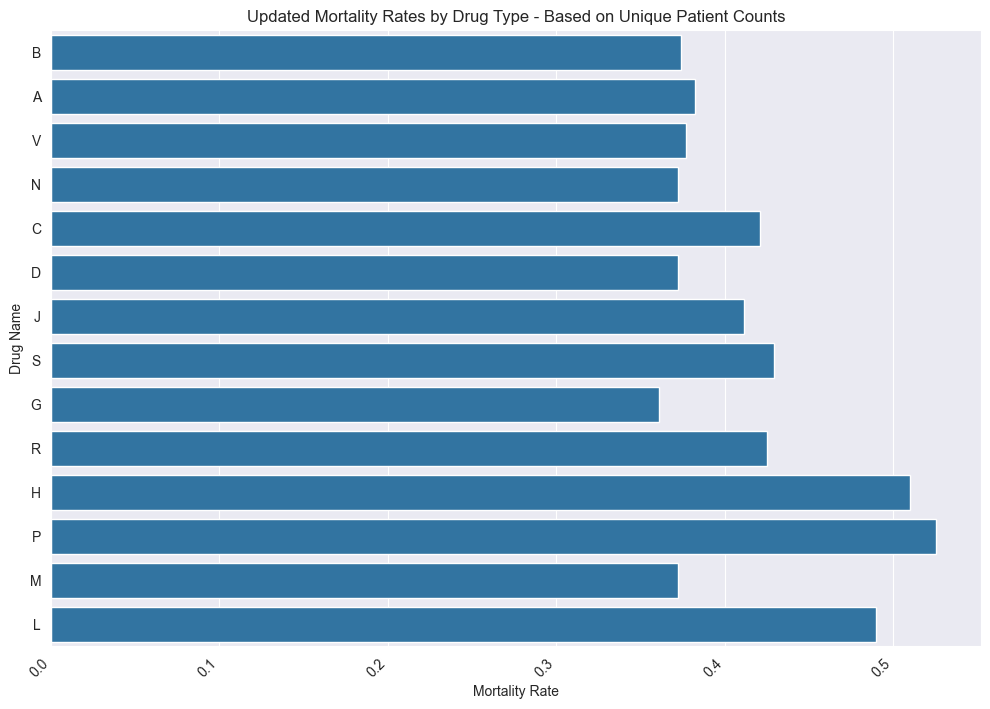

In [280]:
# First, calculating unique patients per drug and their expiration status
unique_patient_drug_expire = drug_patient_complete.groupby([drug_class, 'EXPIRE_FLAG'])['SUBJECT_ID'].nunique().unstack(fill_value=0)

# Calculate the new mortality rate based on unique patient counts
unique_patient_drug_expire['Mortality Rate'] = unique_patient_drug_expire[1] / (unique_patient_drug_expire[0] + unique_patient_drug_expire[1])

# Preparing the visualization data, focusing on the top drugs
new_heatmap_data = unique_patient_drug_expire.loc[top_drugs, ['Mortality Rate']]

# Plotting the heatmap for the updated mortality rates
plt.figure(figsize=(10, 8))
sns.heatmap(data=new_heatmap_data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Mortality Rate'}, fmt=".2f")
plt.title('Updated Mortality Rates by Drug Type - Based on Unique Patient Counts')
plt.xlabel('Mortality Rate')
plt.ylabel('Drug Name')
plt.xticks(rotation=45, ha='right')
plt.show()

# Plotting the bar chart for the updated mortality rates
plt.figure(figsize=(12, 8))
sns.barplot(x='Mortality Rate', y=new_heatmap_data.reset_index()[drug_class], data=new_heatmap_data.reset_index())
plt.title('Updated Mortality Rates by Drug Type - Based on Unique Patient Counts')
plt.xlabel('Mortality Rate')
plt.ylabel('Drug Name')
plt.xticks(rotation=45, ha='right')
plt.show()

In [281]:
heatmap_data.head()

,Mortality Rate
atc1,
A,0.441384
B,0.456678
C,0.494329
D,0.420405
G,0.409490


In [282]:
drug_patient_complete

,SUBJECT_ID,atc1,Total_Duration,Prescription_Count,EXPIRE_FLAG
0,4,A,14,10,0
1,4,B,9,5,0
2,4,D,13,2,0
3,4,G,6,1,0
4,4,J,13,2,0
...,...,...,...,...,...
274533,99999,M,4,1,0
274534,99999,N,1,1,0
274535,99999,R,1,1,0
274536,99999,S,2,2,0


In [283]:
drug_mortality_summary[('Prescription_Count', 1)] 

atc1
A    426817
B    692974
C     60752
D     52208
G     26691
H     12630
J     58423
L      8058
M      3235
N     44977
P      3926
R     27036
S     68078
V    231905
Name: (Prescription_Count, 1), dtype: int64

In [284]:
# Calculate Pearson's correlation coefficient between duration and mortality status
correlation_coef, p_value = pearsonr(mortality_duration['DURATION'], mortality_duration['EXPIRE_FLAG'])

print(f"Pearson's correlation coefficient: {correlation_coef}, P-value: {p_value}")

Pearson's correlation coefficient: 0.12641865829317547, P-value: 8.168377736423415e-134


# Logistic Regression

In [285]:
# Ensure 'DURATION' is numeric
mortality_drug_type['DURATION'] = pd.to_numeric(mortality_drug_type['DURATION'], errors='coerce')

# Drop any rows with missing values in 'DURATION' or 'EXPIRE_FLAG'
mortality_drug_type.dropna(subset=['DURATION', 'EXPIRE_FLAG'], inplace=True)

# Convert 'EXPIRE_FLAG' to a numeric type if it's not already
mortality_drug_type['EXPIRE_FLAG'] = mortality_drug_type['EXPIRE_FLAG'].astype(int)

In [286]:
np.asarray(mortality_drug_type[['DURATION', drug_class]])

array([[14, 'A'],
       [9, 'B'],
       [13, 'D'],
       ...,
       [1, 'R'],
       [2, 'S'],
       [12, 'V']], dtype=object)

In [289]:
mortality_drug_type.dtypes

SUBJECT_ID      int64
atc1           object
DURATION        int64
EXPIRE_FLAG     int64
dtype: object

In [290]:
mortality_drug_type.head()

,SUBJECT_ID,atc1,DURATION,EXPIRE_FLAG
0,4,A,14,0
1,4,B,9,0
2,4,D,13,0
3,4,G,6,0
4,4,J,13,0


In [288]:
# Prepare the dataset for logistic regression
X = pd.get_dummies(mortality_drug_type[['DURATION', drug_class]], drop_first=True)
y = mortality_drug_type['EXPIRE_FLAG']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the logistic regression model
model = sm.Logit(y, X).fit()

# Display the model summary
print(model.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).